In [1]:
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 949.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=74f2cfbb672e47cdbb6164a35158fd4b89612f8f44b2078a32b50acd86ecda4a
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [2]:
import json
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [3]:
def plotClassDistri(df, cols, title):
    
    labels_val = dict(df[cols].value_counts())
    sorted_vals = [labels_val[key] for key in sorted(labels_val.keys())]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.bar( sorted(labels_val.keys()), sorted_vals)
    plt.title("Distribution of " + title + " Intensity", fontsize=20)
    plt.xlabel("Levels of " + title + " Intensity",fontsize=16)
    plt.ylabel("No. Of Reviews", fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=0)
    plt.show()

In [7]:
## Load Data
## DATASET PATH ##
PATH = '../dataset.csv'
df = pd.read_csv(PATH)

## DECIDE WHICH ROWS TO DROP ##
# df.drop(['Review ID', 'Venue', 'Journal name', 'ESI', 'Article title', 'Review URL'], axis=1, inplace=True)
df.drop([''], axis=1, inplace=True) ## HINT : AT THE END WE MUST HAVE ONLY "review", "N/C" and "Tone" 
df.dropna(inplace=True)
df

,review,N/C,Tone
0,"Still , it would be nice to know what is going...",1,3
1,"- At last , some relief. The paper ended",1,1
2,Even if they are loose - identifying the degre...,1,3
3,There are a few things I think could be cleare...,1,2
4,The paper is quite cumbersome and should be im...,1,2
...,...,...,...
2710,"This seems like a fishing expedition, please e...",5,2
2711,The scales appear to be not divided into quart...,5,1
2712,My summary assessment of the paper is as follo...,5,2
2713,But there have been treatments along these exa...,5,3


In [8]:
df.isna().sum()

review    0
N/C       0
Tone      0
dtype: int64

In [7]:
X = df.review.values
y = df.Tone.values

X.shape, y.shape

((2713,), (2713,))

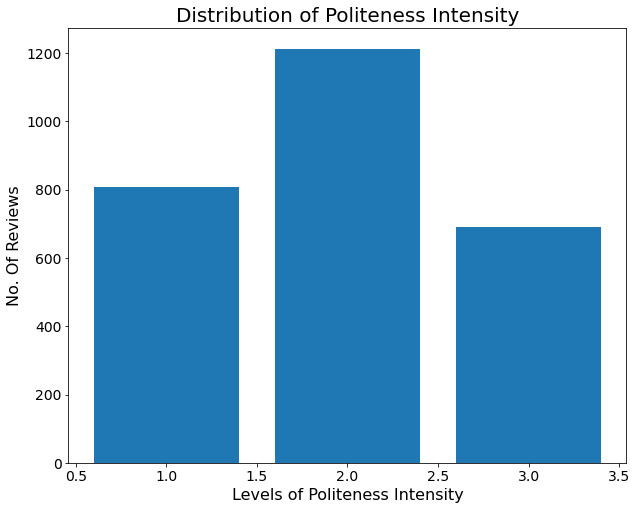

In [8]:
plotClassDistri(df,'Tone', 'Politeness')

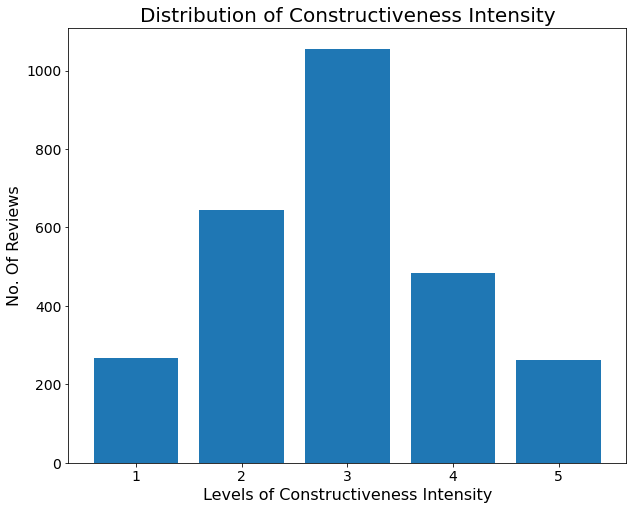

In [9]:
plotClassDistri(df,'N/C', 'Constructiveness')

In [10]:
df.Tone.value_counts()

2.0    1213
1.0     809
3.0     691
Name: Tone, dtype: int64

In [11]:
df['N/C'].value_counts()

3.0    1056
2.0     644
4.0     484
1.0     267
5.0     262
Name: N/C, dtype: int64

# Handle Imbalance 

### UPSAMPLING LESS FREQ. LEVELS

In [12]:
MAX_RECORDS_PER_CLASSS = df['N/C'].value_counts().max()
UNIQUE_CATEGORIES = df['N/C'].unique()

upsampled_df = pd.DataFrame(columns= df.columns)
for label in UNIQUE_CATEGORIES:
    df_class = df[df['N/C'] == label]
    # print(label , ": ", df_class.shape)
    df_class = df_class.sample(MAX_RECORDS_PER_CLASSS , replace=True)
    print(label , " : ", df_class.shape)
    upsampled_df = pd.concat([upsampled_df, df_class], axis=0)

upsampled_df.reset_index(inplace=True)
upsampled_df.drop('index', axis=1, inplace=True)
print("\nFINAL UPSAMPLED DATAFRAME : " , upsampled_df.shape)

4.0  :  (1056, 3)
5.0  :  (1056, 3)
3.0  :  (1056, 3)
2.0  :  (1056, 3)
1.0  :  (1056, 3)

FINAL UPSAMPLED DATAFRAME :  (5280, 3)


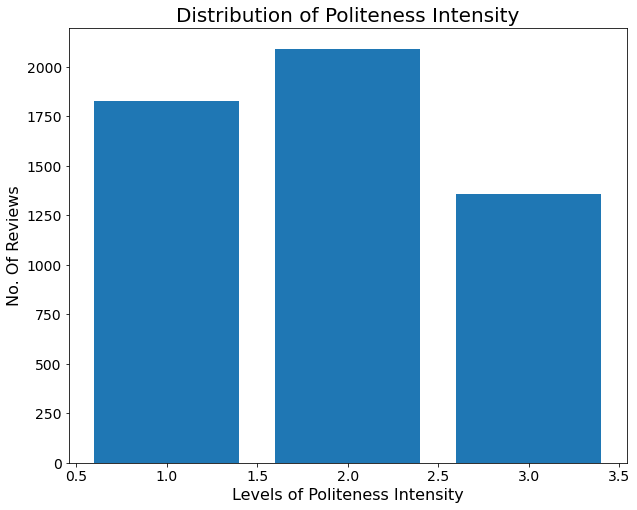

In [13]:
plotClassDistri(upsampled_df, 'Tone', 'Politeness')

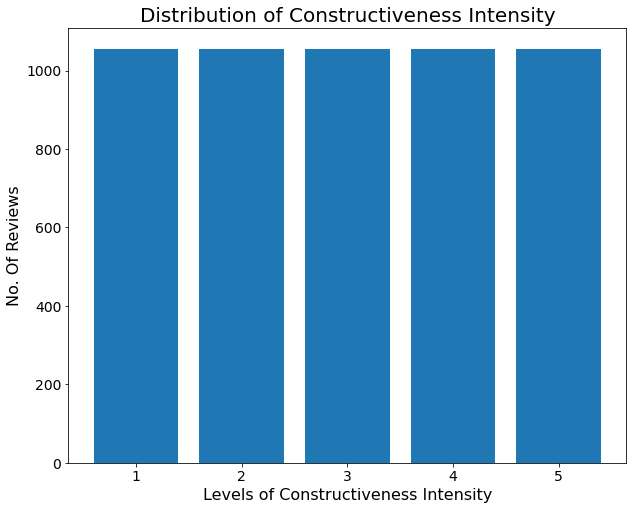

In [14]:
plotClassDistri(upsampled_df, 'N/C', 'Constructiveness')

In [15]:
upsampled_df.to_csv('upsampled_data.csv', index=False)

# ONE HOT ENCODING

In [16]:
df = pd.read_csv('./upsampled_data.csv')
df.dropna(inplace=True)

In [17]:
df.head()

,review,N/C,Tone
0,Training the classification features along wit...,4.0,2.0
1,Although there are obvious differences in male...,4.0,3.0
2,All figures ( but in particular Figure 3 ) nee...,4.0,3.0
3,- interesting path through variational dropout...,4.0,3.0
4,Training the classification features along wit...,4.0,2.0


In [18]:
# LABEL ENCODER

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

ohe = OneHotEncoder(drop=None, dtype= np.int32,  handle_unknown='error')
transformer = make_column_transformer(
    ( ohe, ['Tone', 'N/C']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)

In [19]:
transformed_df.head(3)

,onehotencoder__Tone_1.0,onehotencoder__Tone_2.0,onehotencoder__Tone_3.0,onehotencoder__N/C_1.0,onehotencoder__N/C_2.0,onehotencoder__N/C_3.0,onehotencoder__N/C_4.0,onehotencoder__N/C_5.0,remainder__review
0,0,1,0,0,0,0,1,0,Training the classification features along wit...
1,0,0,1,0,0,0,1,0,Although there are obvious differences in male...
2,0,0,1,0,0,0,1,0,All figures ( but in particular Figure 3 ) nee...


In [20]:
cols = ['IMP', 'NP', 'P', 'HNC', 'NC', 'NN', 'C', 'HC', 'review']
ordered_cols = ['review','IMP', 'NP', 'P', 'HNC', 'NC', 'NN', 'C', 'HC']
processed_df = pd.DataFrame(transformed, columns=cols)
processed_df = processed_df[ordered_cols]
processed_df['Tone'] =  df.Tone
processed_df['N/C'] =  df['N/C']


# SHUFFLE
processed_df = processed_df.sample(frac=1).reset_index(drop=True)
processed_df.head()

,review,IMP,NP,P,HNC,NC,NN,C,HC,Tone,N/C
0,It seems revised version of paper. Authors add...,0,0,1,0,0,1,0,0,3.0,3.0
1,While they provide some good references to sup...,0,1,0,0,0,0,1,0,2.0,4.0
2,I also think that the authors might benefit fr...,0,0,1,0,0,0,1,0,3.0,4.0
3,I am not very excited about this. There must b...,1,0,0,1,0,0,0,0,1.0,1.0
4,While the Re LU activation is very common in N...,1,0,0,0,0,0,1,0,1.0,4.0


In [21]:
processed_df.to_csv('upsampled_ohe_politnessLevel.csv', index=False)

# TRAIN TEST SPLIT

In [22]:
df = pd.read_csv('./upsampled_ohe_politnessLevel.csv')
df.head()

,review,IMP,NP,P,HNC,NC,NN,C,HC,Tone,N/C
0,It seems revised version of paper. Authors add...,0,0,1,0,0,1,0,0,3.0,3.0
1,While they provide some good references to sup...,0,1,0,0,0,0,1,0,2.0,4.0
2,I also think that the authors might benefit fr...,0,0,1,0,0,0,1,0,3.0,4.0
3,I am not very excited about this. There must b...,1,0,0,1,0,0,0,0,1.0,1.0
4,While the Re LU activation is very common in N...,1,0,0,0,0,0,1,0,1.0,4.0


In [24]:
train, val, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.85*len(df))])
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.shape , test.shape, val.shape 

((4224, 11), (792, 11), (264, 11))

In [25]:
train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)
val.to_csv('val.csv', index = False)

#  EMBEDS FOR TRAIN, TEST AND VALIDATION

In [26]:
# politness_categories = ['HIMP', 'IMP', 'N', 'P', 'HP']
y_categories = ['HNC', 'NC', 'NN', 'C', 'HC', 'IMP', 'NP', 'P']
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('val.csv')

In [27]:
train.shape , test.shape, val.shape

((4224, 11), (792, 11), (264, 11))

In [28]:
train.head(3)

,review,IMP,NP,P,HNC,NC,NN,C,HC,Tone,N/C
0,"Furthermore, in addition to Atom, Bond and Rin...",0,0,1,0,0,0,0,1,3.0,5.0
1,In my opinion the introduction of SVM can be s...,0,1,0,0,0,0,0,1,2.0,5.0
2,It is shocking to read how statistics are bein...,1,0,0,0,1,0,0,0,1.0,2.0


In [29]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [30]:
def loadModel(embed_model_name):
    tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
    embed_model = AutoModel.from_pretrained(embed_model_name)
    
    return embed_model, tokenizer

def sent2embed(embed_model, tokenizer, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = embed_model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# PRE-PROCESS 
def BertEmbed(reviews, embed_model, tokenizer):
    
    embed_arr = []
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(embed_model, tokenizer, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])

    embed_train_arr = tf.stack(embed_arr)

    return embed_train_arr

In [31]:
# # TEST WITH 1 SAMPLE
# embed_model,tokenizer = loadModel('gsarti/scibert-nli')
# BertEmbed(val.review, embed_model)

In [32]:
import pickle

def automateEmbedAndSave(embed_model_name, name):
# EMBEDS
    print(f'\n\n***** {name} *****')
    embed_model,tokenizer = loadModel(embed_model_name)
    embeds_train = BertEmbed(train.review, embed_model, tokenizer)
    embeds_test = BertEmbed(test.review, embed_model, tokenizer)
    embeds_val = BertEmbed(val.review, embed_model, tokenizer)
    print(f'TRAIN SHAPE : {embeds_train.shape}\nTEST SHAPE : {embeds_test.shape}\nVAL SHAPE : {embeds_val.shape}')
    
    
# SAVE FILES
    # TRAIN
    save_path = name+'_train.pickle'
    with open(save_path, 'wb') as handle:
        pickle.dump(embeds_train, handle)
        handle.close()
    print('SAVED TRAIN TO PICKLE --> ', name)
    
    # TEST
    save_path = name+'_test.pickle'
    with open(save_path, 'wb') as handle:
        pickle.dump(embeds_test, handle)
        handle.close() 
    print('SAVED TEST TO PICKLE --> ', name)
    
    # VAL
    save_path = name+'_val.pickle'
    with open(save_path, 'wb') as handle:
        pickle.dump(embeds_val, handle)
        handle.close() 
    print('SAVED VAL TO PICKLE --> ', name)
    


In [33]:
# LOAD EMBEDS DATASET

def loadPickle(name):
    
    LOAD_PATH = './'+name+'_train.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        train_embeds = pickle.load(handle)
        handle.close()

    LOAD_PATH = './'+name+'_test.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        test_embeds = pickle.load(handle)
        handle.close()
        
    LOAD_PATH = './'+name+'_val.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        val_embeds = pickle.load(handle)
        handle.close()
        
    y_train = pd.read_csv('y_train.csv')
    y_val = pd.read_csv('y_val.csv')
    y_test = pd.read_csv('y_test.csv')
    
    print('\n***** LOADED '+ name+' *****\n')
    print(f'TRAIN SHAPE : {train_embeds.shape}\nTEST SHAPE : {test_embeds.shape}\nVAL SHAPE : {val_embeds.shape}\nY-TRAIN SHAPE : {y_train.shape}\nY-TEST SHAPE : {y_test.shape}\nY-VAL SHAPE : {y_val.shape}')

    return train_embeds, test_embeds, val_embeds, y_train, y_test, y_val

In [34]:
y_train = train[y_categories]
y_test = test[y_categories]
y_val = val[y_categories]

y_train.to_csv('y_train.csv', index = False)
y_test.to_csv('y_test.csv', index = False)
y_val.to_csv('y_val.csv', index = False)

## A) SCIBERT

In [35]:
embed_model_name = 'gsarti/scibert-nli'
automateEmbedAndSave(embed_model_name, 'SCIBERT')



***** SCIBERT *****


Downloading:   0%|          | 0.00/135 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/217k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2022-12-24 18:28:34.002027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:28:34.003491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:28:34.004442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:28:34.007243: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [36]:
sci_train_embeds, sci_test_embeds, sci_val_embeds, y_train, y_test, y_val = loadPickle('SCIBERT')


***** LOADED SCIBERT *****

TRAIN SHAPE : (4224, 1, 768)
TEST SHAPE : (792, 1, 768)
VAL SHAPE : (264, 1, 768)
Y-TRAIN SHAPE : (4224, 8)
Y-TEST SHAPE : (792, 8)
Y-VAL SHAPE : (264, 8)


In [37]:
sci_train_embeds.shape, sci_test_embeds.shape, sci_val_embeds.shape

(TensorShape([4224, 1, 768]),
 TensorShape([792, 1, 768]),
 TensorShape([264, 1, 768]))

## B) TOXIC-BERT
https://huggingface.co/troesy/toxicBERT_3epoch?text=My+name+is+Clara+and+I+live+in+Berkeley%2C+California.

In [38]:
embed_model_name = 'troesy/toxicBERT_3epoch'
# embed_model_name ='mohsenfayyaz/bert-base-uncased-toxicity'

automateEmbedAndSave(embed_model_name, 'TOXIC-BERT')



***** TOXIC-BERT *****


Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/835 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415M [00:00<?, ?B/s]

Some weights of the model checkpoint at troesy/toxicBERT_3epoch were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at troesy/toxicBERT_3epoch and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
toxic_train_embeds, toxic_test_embeds, toxic_val_embeds, y_train, y_test, y_val = loadPickle('TOXIC-BERT')


***** LOADED TOXIC-BERT *****

TRAIN SHAPE : (4224, 1, 768)
TEST SHAPE : (792, 1, 768)
VAL SHAPE : (264, 1, 768)
Y-TRAIN SHAPE : (4224, 8)
Y-TEST SHAPE : (792, 8)
Y-VAL SHAPE : (264, 8)


## C) HATE-BERT
https://huggingface.co/GroNLP/hateBERT <br>
https://aclanthology.org/2021.woah-1.3/

In [40]:
embed_model_name ='GroNLP/hateBERT'
automateEmbedAndSave(embed_model_name, 'HATE-BERT')



***** HATE-BERT *****


Downloading:   0%|          | 0.00/151 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [41]:
hate_train_embeds, hate_test_embeds, hate_val_embeds, y_train, y_test, y_val = loadPickle('HATE-BERT')


***** LOADED HATE-BERT *****

TRAIN SHAPE : (4224, 1, 768)
TEST SHAPE : (792, 1, 768)
VAL SHAPE : (264, 1, 768)
Y-TRAIN SHAPE : (4224, 8)
Y-TEST SHAPE : (792, 8)
Y-VAL SHAPE : (264, 8)


## D) RoBERTa

In [42]:
embed_model_name ='roberta-base'
automateEmbedAndSave(embed_model_name, 'RoBERTa')



***** RoBERTa *****


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [43]:
roberta_train_embeds, roberta_test_embeds, roberta_val_embeds, y_train, y_test, y_val = loadPickle('RoBERTa')


***** LOADED RoBERTa *****

TRAIN SHAPE : (4224, 1, 768)
TEST SHAPE : (792, 1, 768)
VAL SHAPE : (264, 1, 768)
Y-TRAIN SHAPE : (4224, 8)
Y-TEST SHAPE : (792, 8)
Y-VAL SHAPE : (264, 8)
